In [1573]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import keras

# Generate synthetic data

In [1423]:
def my_sin(x):
    return math.sin(2 * math.pi * x + 1.5 * math.pi)

def get_one_wave(min_len=7, max_len=25):
    assert min_len % 2
    assert max_len % 2
    length = random.randint(min_len, max_len)
    if not length % 2:
        length += 1
    step = 1 / (length - 1)
    return list(map(
        lambda i: my_sin(i * step),
        range(0, length)
    ))

def get_data(length):
    data = []
    indices = []
    i = 0
    while len(data) < length:
        one_wave = get_one_wave()
        data.extend(one_wave[:-1])
        indices.append((i, i + len(one_wave) // 2))
        i += len(one_wave) - 1
    if indices[-1][1] >= length:
        indices.pop(-1)
    return data[:length], indices

## Plot Example

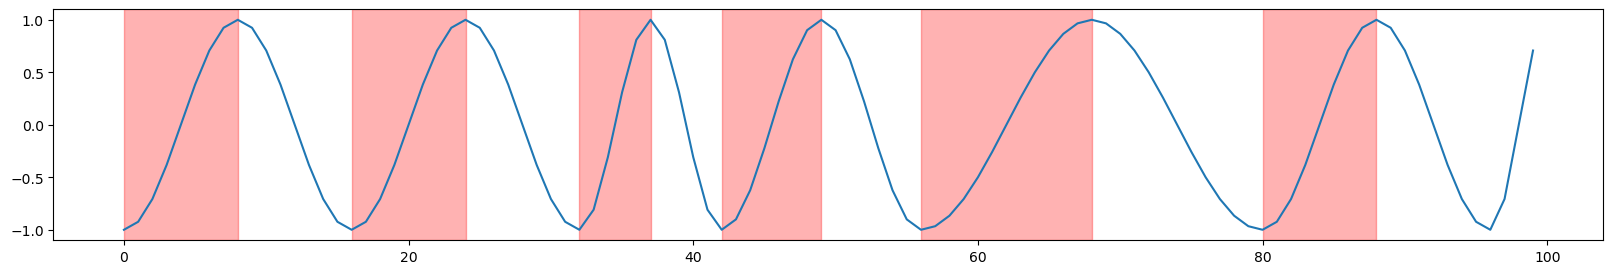

In [1424]:
data, indices = get_data(100)
plt.figure(figsize=(20, 3))
for start, stop in indices:
    plt.axvspan(start, stop, color='red', alpha=0.3)
plt.plot(data)

## Make Trainig data

In [1498]:
window_size = 51

In [1499]:
data, indices = get_data(100_000)

In [1500]:
data = np.array(data)

In [1501]:
data_min = data.min()
data_max = data.max()
adj_data = np.round(((data + abs(data_min)) / (abs(data_min) + abs(data_max))) * (window_size - 1)).astype(int)
del data_min
del data_max
print(adj_data.min())
print(adj_data.max())

0
50


In [1587]:
def get_enclosing_indice(i):
    if i > indices[-1][0]:
        return -1 , None
    try:
        return next(
            (j, indice) for j, indice in enumerate(indices)
            if indice[0] <= i <= indice[1]
        )
    except StopIteration:
        return -1 , None

def get_previous_enclosing_indice(i):
    if i < indices[0][1]:
        return -1 , None
    if i >= indices[-1][1]:
        return len(indices) - 1, indices[-1]
    try:
        return next(
            (j, indice) for j, indice, next_indice in zip(
                range(0, len(indices) - 1),
                indices[::1],
                indices[1::1]
            )
            if i < next_indice[1]
        )
    except StopIteration:
        return -1 , None

def get_next_enclosing_indice(i):
    try:
        return next(
            (j, indice) for j, indice in enumerate(indices)
            if i <= indice[0]
        )
    except StopIteration:
        return -1 , None


def is_enclosing_indice(i, indices):
    try:
        return next(True for start, end in indices if start <= i <= end)
    except StopIteration:
        return False

def get_x(i):
    x = np.zeros((window_size, window_size))
    for j, val in enumerate(adj_data[i - window_size : i]):
        x[j][val] = 1.
    return x
    

def get_y(i):
    a, _, = get_next_enclosing_indice(i - window_size)
    assert a != -1
    b, _ = get_previous_enclosing_indice(i - 1)
    assert b != -1
    window_indices = indices[a : b + 1]
    return [
        1. if is_enclosing_indice(j, window_indices) else 0.
        for j in range(i - window_size, i)
    ]

def get_xy(i):
    return get_x(i), get_y(i)

In [1629]:
x, y = zip(*map(
    get_xy,
    range(window_size, len(data), window_size)
))
x = np.array(x)
x = np.rot90(x, k=1, axes=(1, 2))
y = np.array(y)
print(x.shape)
print(y.shape)

(1960, 51, 51)
(1960, 51)


## Visualize a training window

In [1625]:
def find_indices(values):
    indices = []
    try:
        start = values.index(1)
    except ValueError:
        return indices
    while True:
        if start == len(values) - 1:
            indices.append((start, start))
            return indices
        try:
            stop = values.index(0, start + 1)
        except ValueError:
            indices.append((start, len(values) - 1))
            return indices
        indices.append((start, stop - 1))
        try:
            start = values.index(1, stop + 1)
        except ValueError:
            return indices

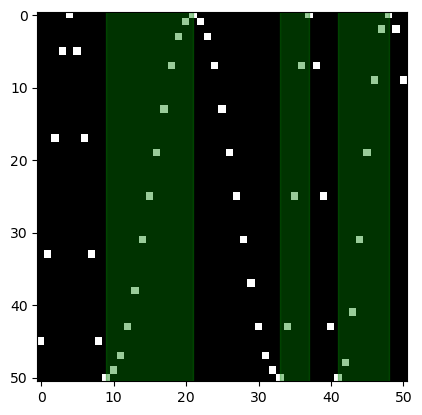

In [2125]:
i = random.randrange(len(x))
for start, stop in find_indices(y[i].tolist()):
    plt.axvspan(start, stop, color='green', alpha=0.4)
plt.imshow(x[i], cmap='gray')

# Randomize

In [1636]:
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

# Split into train and test data

In [1637]:
train_length = round(len(x) * 0.6)
x_train = x[:train_length]
y_train = y[:train_length]
x_test = x[train_length:]
y_test = y[train_length:]
print(len(x_train))
print(len(x_test))

1176
784


# Build a (proposal) model

In [2126]:
input_shape = window_size, window_size, 1

In [2180]:
def make_model():
    return keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(window_size, activation='sigmoid'),
    ])
    
model = make_model()

# Train the model

In [2181]:
epochs = 40
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.01
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/40
30/30 [==============================] - 15s 306ms/step - loss: 0.4488 - binary_accuracy: 0.7994 - val_loss: 0.2632 - val_binary_accuracy: 0.9104 - lr: 0.0010
Epoch 2/40
30/30 [==============================] - 1s 27ms/step - loss: 0.1821 - binary_accuracy: 0.9419 - val_loss: 0.1494 - val_binary_accuracy: 0.9487 - lr: 0.0010
Epoch 3/40
30/30 [==============================] - 1s 23ms/step - loss: 0.0940 - binary_accuracy: 0.9761 - val_loss: 0.1025 - val_binary_accuracy: 0.9649 - lr: 0.0010
Epoch 4/40
30/30 [==============================] - 1s 26ms/step - loss: 0.0544 - binary_accuracy: 0.9902 - val_loss: 0.0809 - val_binary_accuracy: 0.9737 - lr: 0.0010
Epoch 5/40
30/30 [==============================] - 1s 31ms/step - loss: 0.0353 - binary_accuracy: 0.9955 - val_loss: 0.0621 - val_binary_accuracy: 0.9803 - lr: 0.0010
Epoch 6/40
30/30 [==============================] - 1s 23ms/step - loss: 0.0225 - binary_accuracy: 0.9983 - val_loss: 0.0551 - val_binary_accuracy: 0.9815 - l

# Evaluate

In [2182]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

25/25 [==============================] - 2s 76ms/step - loss: 0.0339 - binary_accuracy: 0.9892
Test Loss: 0.033948447555303574, Test Accuracy: 0.9891706109046936


In [2073]:
# Test Loss: 0.0502689890563488, Test Accuracy: 0.9850939512252808

In [2183]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])

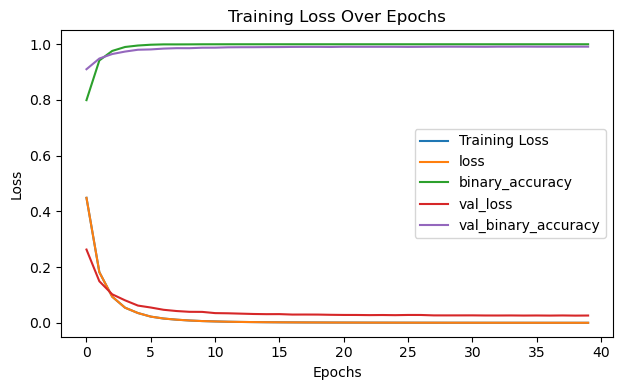

In [2184]:
# Plotting training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

for key in ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']:
    plt.plot(history.history[key], label=key)
    plt.legend()

plt.tight_layout()
plt.show()

# Plot prediction

In [2185]:
y_predicted = model.predict(x_test)

25/25 [==============================] - 1s 14ms/step


In [2186]:
y_predicted_filtered = (y_predicted > 0.5).astype(int)

In [2223]:
def combine_indices(indices, max_distance=2):
    idxs = list(range(len(indices)))
    filtered_idxs = list(filter(
        lambda j: indices[j + 1][0] - indices[j][1] <= max_distance,
        range(len(indices) - 1)
    ))
    result = [
        indices[j] for j in filter(
            lambda x: x not in filtered_idxs and x - 1 not in filtered_idxs,
            idxs
        )
    ]
    j = 0
    while j < len(filtered_idxs):
        try:
            stop = next(
                k for k in range(j + 1, len(filtered_idxs))
                if filtered_idxs[k] - filtered_idxs[k - 1] > 1
            )
        except StopIteration:
            stop = len(filtered_idxs)
        result.append((
            indices[filtered_idxs[j]][0],
            indices[filtered_idxs[j] + 1][1]
        ))
        j = stop
    return sorted(result, key=lambda x: x[0])

def filter_indices(indices, min_distance=2):
    return list(filter(
        lambda indice: indice[1] - indice[0] >= min_distance,
        indices
    ))

def find_process_indices(prediction, min_distance=2, max_combine_distance=2):
    indices = find_indices(prediction.tolist() if isinstance(prediction, np.ndarray) else prediction)
    indices = combine_indices(indices, min_distance)
    indices = filter_indices(indices, max_combine_distance)
    return indices

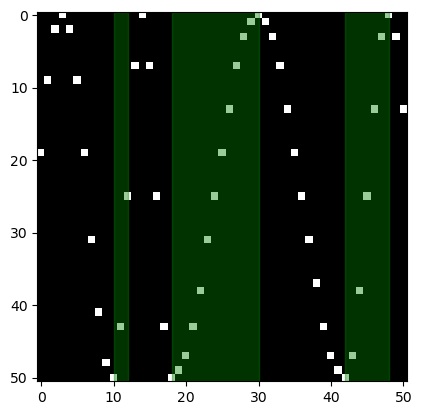

In [2240]:
i = random.randrange(len(x_test))
for start, stop in find_process_indices(y_predicted_filtered[i]):
    plt.axvspan(start, stop, color='green', alpha=0.4)
plt.imshow(x_test[i], cmap='gray')